In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
import unicodedata
import re
from env import user, password, host
import acquire
import prepare

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

1) Spam Data

    a) Load the spam data set.

In [3]:
url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


b) Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

In [4]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore').lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]


def clean(text):
    '''Simplified text cleaning function'''
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return re.sub(r"[^w\s]", '', text).lower()

In [5]:
# create df of spam only
spam = df[df.label == 'spam']
spam

,label,text
id,,
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."
...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...


In [6]:
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['count', 'percent']
    labels
    return labels

show_counts_and_ratios(df, "label")

,count,percent
ham,4825,0.865937
spam,747,0.134063


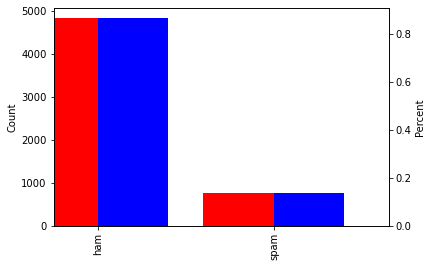

In [7]:
x = show_counts_and_ratios(df, "label")

fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4
x["count"].plot(kind='bar', color='red', ax=ax, width=width, position=1)
x["percent"].plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

ax.set_ylabel('Count')
ax2.set_ylabel('Percent')

plt.show()

In [8]:
# clean and separate ham/spam words
ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))

In [9]:
# frequency
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [10]:
word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,all,ham,spam
0,3,0,3
008704050406,2,0,2
0089my,1,0,1
0121,1,0,1
01223585236,1,0,1


In [11]:
counts = pd.concat([ham_freq, spam_freq, all_freq], axis=1).fillna(0).astype(int)
counts.columns = ['ham', 'spam', 'all']
counts.head()

,ham,spam,all
im,449,13,462
get,314,83,397
go,273,31,304
ok,272,5,277
dont,257,22,279


In [12]:
counts.ham.sort_values(ascending=False).head()

im      449
get     314
go      273
ok      272
dont    257
Name: ham, dtype: int64

In [13]:
counts.spam.sort_values(ascending=False).head()

call    359
free    216
txt     150
ur      144
text    137
Name: spam, dtype: int64

In [14]:
# highest frequency 'spam' words that don't appear in 'ham'
counts[counts.ham==0].sort_values('spam', ascending=False).head(10)

,ham,spam,all
claim,0,115,115
prize,0,94,94
tone,0,73,73
guaranteed,0,50,50
18,0,43,43
awarded,0,38,38
a1000,0,35,35
150ppm,0,34,34
a2000,0,31,31
a150,0,27,27


In [15]:
# highest frequency 'ham' words that don't appear in 'spam'
counts[counts.spam==0].sort_values('ham', ascending=False).head(10)

,ham,spam,all
lor,160,0,160
later,134,0,134
da,132,0,132
say,118,0,118
i_,117,0,117
thats,94,0,94
ask,88,0,88
said,86,0,86
amp,82,0,82
didnt,79,0,79


Text(0.5, 1.0, 'Proportion of Spam vs Ham for the 20 most common words')

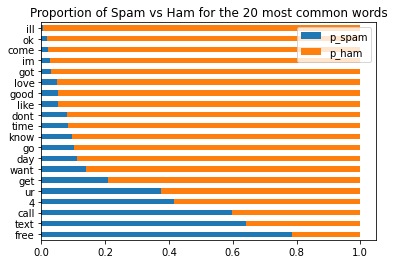

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# figure out the percentage of spam vs ham
(word_counts
 .assign(p_spam=word_counts.spam / word_counts['all'],
         p_ham=word_counts.ham / word_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 20 most common words')

In [17]:
word_counts['all'].sort_values(ascending=False).head(20)

call    600
im      462
get     397
ur      384
go      304
4       287
dont    279
ok      277
free    275
know    267
come    247
like    245
day     241
got     238
ill     237
good    235
time    232
text    214
want    213
love    203
Name: all, dtype: int64

In [18]:
from wordcloud import WordCloud

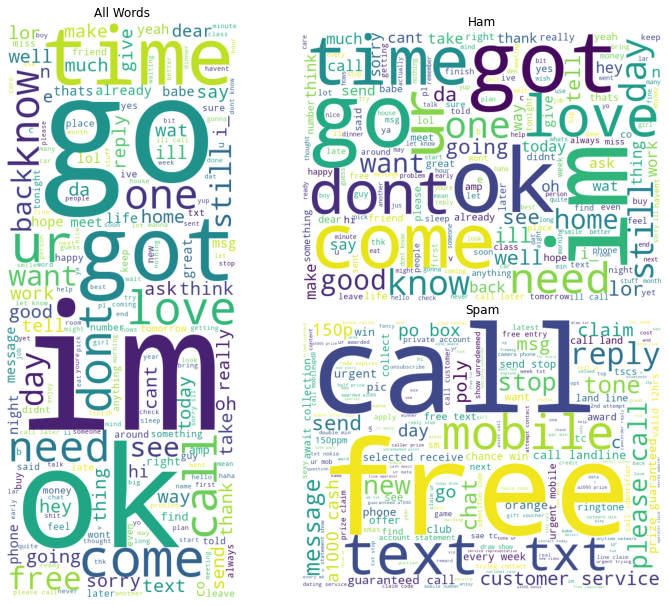

In [19]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
ham_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ham_words))
spam_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(spam_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(ham_cloud)
axs[2].imshow(spam_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Ham')
axs[2].set_title('Spam')

for ax in axs: ax.axis('off')


In [20]:
bigrams = nltk.ngrams(ham_words, 2)
list(bigrams)[:10]

[('go', 'jurong'),
 ('jurong', 'point'),
 ('point', 'crazy'),
 ('crazy', 'available'),
 ('available', 'bugis'),
 ('bugis', 'n'),
 ('n', 'great'),
 ('great', 'world'),
 ('world', 'la'),
 ('la', 'e')]

In [21]:
top_15_ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2))
                      .value_counts()
                      .head(15))

top_15_ham_bigrams.head()

(call, later)    52
(ill, call)      48
(let, know)      42
(sorry, ill)     39
(dont, know)     32
dtype: int64

TypeError: reset_index() got an unexpected keyword argument 'ascending'

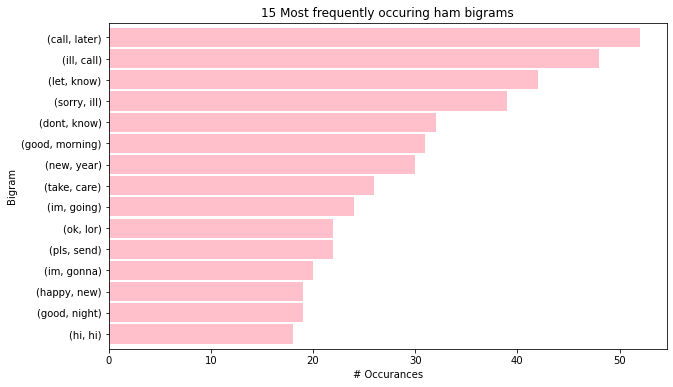

In [22]:
top_15_ham_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('15 Most frequently occuring ham bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_15_ham_bigrams.reset_index(ascending=False)['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [ ]:
bigrams = nltk.ngrams(spam_words, 2)
list(bigrams)[:10]

In [ ]:
top_15_spam_bigrams = (pd.Series(nltk.ngrams(spam_words, 2))
                      .value_counts()
                      .head(15))

top_15_spam_bigrams.head()

In [ ]:
top_15_spam_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('15 Most frequently occuring spam bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_15_spam_bigrams.reset_index(ascending=False)['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [ ]:
from wordcloud import WordCloud

In [23]:
ham_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ham_words))
spam_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(spam_words))

In [24]:
top_15_ham_trigrams = (pd.Series(nltk.ngrams(ham_words, 3))
                      .value_counts()
                      .head(15))

top_15_ham_trigrams.head()

(ill, call, later)      42
(sorry, ill, call)      38
(happy, new, year)      19
(pls, send, message)    13
(right, pls, send)      12
dtype: int64

TypeError: reset_index() got an unexpected keyword argument 'ascending'

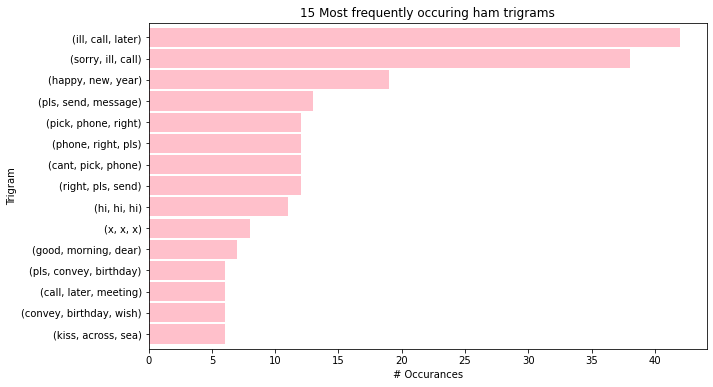

In [25]:
top_15_ham_trigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('15 Most frequently occuring ham trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_15_ham_trigrams.reset_index(ascending=False)['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [ ]:
top_15_spam_trigrams = (pd.Series(nltk.ngrams(spam_words, 3))
                      .value_counts()
                      .head(15))

top_15_spam_trigrams.head()

In [ ]:
top_15_spam_trigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('15 Most frequently occuring spam trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_15_spam_trigrams.reset_index(ascending=False)['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

c) Is there any overlap in the bigrams for the spam data and the ham data?

In [ ]:
# there doesn't appear to be much overlap.  The direction of the conversation appears to be oppositie with the ham data referencing I and the spam you more frequently.  

d) Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

In [26]:
top_10_ham_trigrams = nltk.ngrams(ham_words, 3)
list(top_10_ham_trigrams)[:10]

[('go', 'jurong', 'point'),
 ('jurong', 'point', 'crazy'),
 ('point', 'crazy', 'available'),
 ('crazy', 'available', 'bugis'),
 ('available', 'bugis', 'n'),
 ('bugis', 'n', 'great'),
 ('n', 'great', 'world'),
 ('great', 'world', 'la'),
 ('world', 'la', 'e'),
 ('la', 'e', 'buffet')]

In [27]:
top_15_ham_trigrams = (pd.Series(nltk.ngrams(ham_words, 3))
                      .value_counts()
                      .head(15))

top_15_ham_trigrams.head(15)

(ill, call, later)          42
(sorry, ill, call)          38
(happy, new, year)          19
(pls, send, message)        13
(right, pls, send)          12
(cant, pick, phone)         12
(phone, right, pls)         12
(pick, phone, right)        12
(hi, hi, hi)                11
(x, x, x)                    8
(good, morning, dear)        7
(kiss, across, sea)          6
(convey, birthday, wish)     6
(call, later, meeting)       6
(pls, convey, birthday)      6
dtype: int64

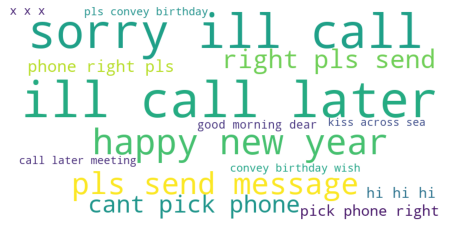

In [28]:
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_15_ham_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [29]:
top_15_spam_trigrams = (pd.Series(nltk.ngrams(spam_words, 3))
                      .value_counts()
                      .head(15))

top_15_spam_trigrams.head()

(prize, guaranteed, call)     21
(call, customer, service)     15
(land, line, claim)           14
(reply, call, 08000930705)    14
(2003, account, statement)    13
dtype: int64

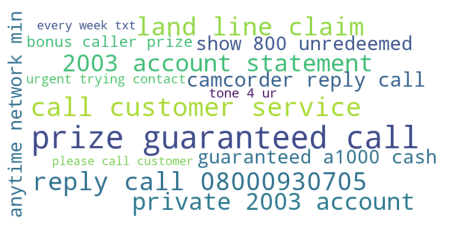

In [30]:
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_15_spam_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

#### 2) Explore the blog articles using the techniques discussed in the exploration lesson.

In [31]:
df = acquire.get_blog_articles()

/Users/albertopuentes/Desktop/codeup-data-science/natural-language-processing-exercises/acquire.py:16: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 16 of the file /Users/albertopuentes/Desktop/codeup-data-science/natural-language-processing-exercises/acquire.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(response.text)


In [32]:
df.head()

,title,published_date,blog_image,content
0,Codeup’s Data Science Career Accelerator is Here!,"September 30, 2018",https://codeup.com/wp-content/uploads/2018/10/...,The rumors are true! The time has arrived. Cod...
1,Data Science Myths,"October 31, 2018",https://codeup.com/wp-content/uploads/2018/10/...,By Dimitri Antoniou and Maggie Giust\nData Sci...
2,Data Science VS Data Analytics: What’s The Dif...,"October 17, 2018",https://codeup.com/wp-content/uploads/2018/10/...,"By Dimitri Antoniou\nA week ago, Codeup launch..."
3,10 Tips to Crush It at the SA Tech Job Fair,"August 14, 2018",None,SA Tech Job Fair\nThe third bi-annual San Anto...
4,Competitor Bootcamps Are Closing. Is the Model...,"August 14, 2018",None,Competitor Bootcamps Are Closing. Is the Model...


In [33]:
prep_df = prepare.prep_df(df, 'content', extra_words = [], exclude_words = [])

In [34]:
prep_df.head()

,title,content,clean,stemmed,lemmatized
0,Codeup’s Data Science Career Accelerator is Here!,The rumors are true! The time has arrived. Cod...,rumors true time arrived codeup officially ope...,rumor true time ha arriv codeup ha offici open...,rumor true time ha arrived codeup ha officiall...
1,Data Science Myths,By Dimitri Antoniou and Maggie Giust\nData Sci...,dimitri antoniou maggie giust data science big...,dimitri antoni maggi giust data scienc big dat...,dimitri antoniou maggie giust data science big...
2,Data Science VS Data Analytics: What’s The Dif...,"By Dimitri Antoniou\nA week ago, Codeup launch...",dimitri antoniou week ago codeup launched imme...,dimitri antoni week ago codeup launch immers d...,dimitri antoniou week ago codeup launched imme...
3,10 Tips to Crush It at the SA Tech Job Fair,SA Tech Job Fair\nThe third bi-annual San Anto...,sa tech job fair third biannual san antonio te...,sa tech job fair third biannual san antonio te...,sa tech job fair third biannual san antonio te...
4,Competitor Bootcamps Are Closing. Is the Model...,Competitor Bootcamps Are Closing. Is the Model...,competitor bootcamps closing model danger prog...,competitor bootcamp close model danger program...,competitor bootcamps closing model danger prog...


In [35]:
lem_words = ' '.join(prep_df.lemmatized)

In [36]:
lem_words

'rumor true time ha arrived codeup ha officially opened application new data science career accelerator 25 seat available immersive program one kind san antonio help land job glassdoors 1 best job america data science method providing actionable intelligence data data revolution ha hit san antonio resulting explosion data scientist position across company like usaa accenture booz allen hamilton heb weve even seen utsa invest 70 cybersecurity center school data science built program specifically meet growing demand industry program 18 week long fulltime handson projectbased curriculum development instruction led senior data scientist maggie giust ha worked heb capital group rackspace along input dozen practitioner hiring partner student work real data set realistic problem entire data science pipeline collection deployment receive professional development training resume writing interviewing continuing education prepare smooth transition workforce focus applied data science immediate im

In [108]:
import nltk.sentiment

sia = nltk.sentiment.SentimentIntensityAnalyzer()

In [109]:
prep_df['sentiment'] = prep_df.lemmatized.apply(lambda doc: sia.polarity_scores(doc)['compound'])

<ipython-input-109-145ba95d3300>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prep_df['sentiment'] = prep_df.lemmatized.apply(lambda doc: sia.polarity_scores(doc)['compound'])


(-0.5, 799.5, 599.5, -0.5)

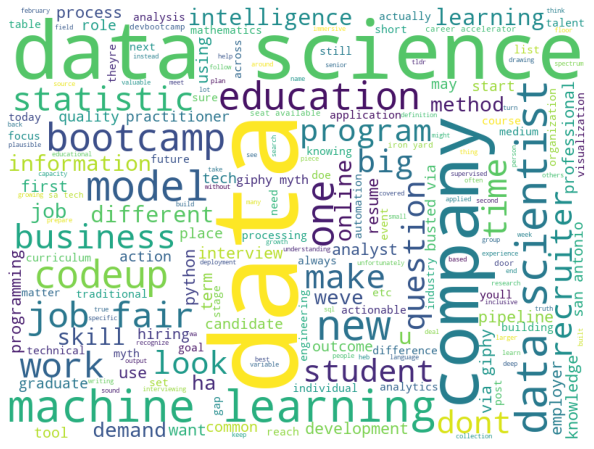

In [41]:
from wordcloud import WordCloud

img = WordCloud(background_color='white', width=800, height=600).generate(lem_words)
plt.figure(figsize=(16, 8))
plt.imshow(img)
plt.axis('off')

In [42]:
top_15_lem_bigrams = (pd.Series(nltk.ngrams(lem_words.split(), 2))
                      .value_counts()
                      .head(15))

top_15_lem_bigrams.head(15)

(data, science)          26
(machine, learning)      14
(data, scientist)        13
(job, fair)               9
(via, giphy)              5
(giphy, myth)             4
(bootcamp, model)         4
(san, antonio)            4
(tech, job)               4
(busted, via)             4
(intelligence, data)      4
(25, seat)                3
(career, accelerator)     3
(big, data)               3
(iron, yard)              3
dtype: int64

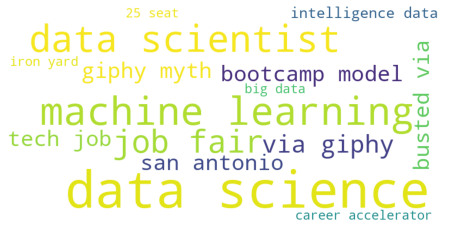

In [43]:
data = {k[0] + ' ' + k[1]: v for k, v in top_15_lem_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

#### 3. Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.

In [44]:
# Explore News Articles
news_df = acquire.get_all_news_articles('categories')

/Users/albertopuentes/Desktop/codeup-data-science/natural-language-processing-exercises/acquire.py:83: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 83 of the file /Users/albertopuentes/Desktop/codeup-data-science/natural-language-processing-exercises/acquire.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(response.text)


In [45]:
news_df

,title,content,category
0,Banks to pay fines if ATMs run out of cash fro...,"The RBI today said that from October 1, 2021, ...",business
1,Ambani's RIL looks to buy Netherlands' 2nd lar...,India's richest person Mukesh Ambani's Relianc...,business
2,Google employees working from home permanently...,Google employees based in the same office befo...,business
3,Zomato's consolidated net loss widens to ₹356 ...,Zomato has reported a consolidated net loss of...,business
4,Second-largest carmaker Volkswagen calls for l...,World's second-largest carmaker Volkswagen has...,business
...,...,...,...
145,Mexico drug cartel threatens to kill news anch...,Mexico's top drug cartel has released a video ...,world
146,Ethiopia urges citizens to join military to fi...,The Ethiopian government on Tuesday urged its ...,world
147,Russia opens new criminal case against top Nav...,Russian authorities have opened a new criminal...,world
148,We had nothing to do with alleged plot to kill...,"Myanmar's military had ""nothing to do"" with an...",world


In [66]:
news_df.category.value_counts()

science          25
entertainment    25
sports           25
business         25
technology       25
world            25
Name: category, dtype: int64

In [76]:
prep_df2 = prepare.prep_df(news_df, 'content', extra_words = [], exclude_words = [])

In [77]:
prep_df2

,title,content,clean,stemmed,lemmatized
0,Banks to pay fines if ATMs run out of cash fro...,"The RBI today said that from October 1, 2021, ...",rbi today said october 1 2021 ' impose penalti...,rbi today said octob 1 2021 ' impos penalti ba...,rbi today said october 1 2021 ' impose penalty...
1,Ambani's RIL looks to buy Netherlands' 2nd lar...,India's richest person Mukesh Ambani's Relianc...,india ' richest person mukesh ambani ' relianc...,india ' richest person mukesh ambani ' relianc...,india ' richest person mukesh ambani ' relianc...
2,Google employees working from home permanently...,Google employees based in the same office befo...,google employees based office covid19 pandemic...,googl employe base offic befor covid19 pandem ...,google employee based office covid19 pandemic ...
3,Zomato's consolidated net loss widens to ₹356 ...,Zomato has reported a consolidated net loss of...,zomato reported consolidated net loss 356 cror...,zomato ha report consolid net loss 356 crore q...,zomato ha reported consolidated net loss 356 c...
4,Second-largest carmaker Volkswagen calls for l...,World's second-largest carmaker Volkswagen has...,world ' secondlargest carmaker volkswagen join...,world ' secondlargest carmak volkswagen ha joi...,world ' secondlargest carmaker volkswagen ha j...
...,...,...,...,...,...
145,Mexico drug cartel threatens to kill news anch...,Mexico's top drug cartel has released a video ...,mexico ' top drug cartel released video threat...,mexico ' top drug cartel ha releas video threa...,mexico ' top drug cartel ha released video thr...
146,Ethiopia urges citizens to join military to fi...,The Ethiopian government on Tuesday urged its ...,ethiopian government tuesday urged capable cit...,ethiopian govern tuesday urg capabl citizen jo...,ethiopian government tuesday urged capable cit...
147,Russia opens new criminal case against top Nav...,Russian authorities have opened a new criminal...,russian authorities opened new criminal case t...,russian author open new crimin case two closes...,russian authority opened new criminal case two...
148,We had nothing to do with alleged plot to kill...,"Myanmar's military had ""nothing to do"" with an...",myanmar ' military nothing alleged plot attack...,myanmar ' militari noth alleg plot attack coun...,myanmar ' military nothing alleged plot attack...


In [48]:
lem_news_words = ' '.join(prep_df2.lemmatized)

In [49]:
lem_news_words[:100]

"rbi today said october 1 2021 ' impose penalty bank white label atm operator atm run cash cashout at"

(-0.5, 799.5, 599.5, -0.5)

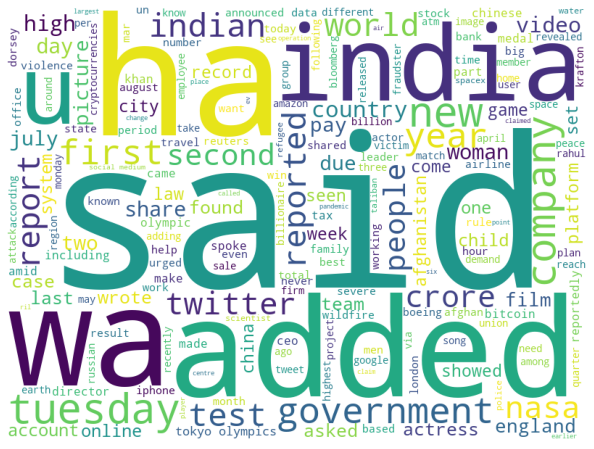

In [50]:
img = WordCloud(background_color='white', width=800, height=600).generate(lem_news_words)
plt.figure(figsize=(16, 8))
plt.imshow(img)
plt.axis('off')

In [51]:
top_35_lem_news_bigrams = (pd.Series(nltk.ngrams(lem_news_words.split(), 2))
                      .value_counts()
                      .head(35))

top_35_lem_news_bigrams.head(35)

(ha, said)                  10
(said, ')                    9
(tokyo, olympics)            8
(india, ')                   7
(company, ')                 6
(social, medium)             5
(men, ')                     5
(ha, urged)                  4
(', spoke)                   4
(crew, member)               4
(nasa, said)                 4
(climate, change)            4
(north, pole)                4
(greene, ')                  4
(neeraj, chopra)             4
(', largest)                 4
(gold, medal)                4
(google, employee)           4
(hockey, team)               4
(', hockey)                  4
(took, instagram)            4
(second, test)               4
(temporarily, suspended)     3
(user, ')                    3
(england, ')                 3
(report, said)               3
(first, time)                3
(added, india)               3
(india, said)                3
(said, china)                3
(woman, ')                   3
(chopra, said)               3
(year, a

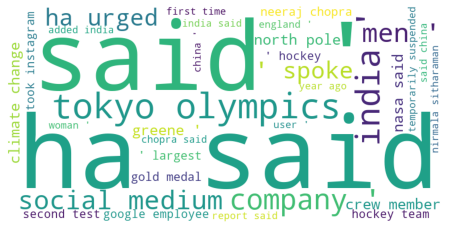

In [52]:
data = {k[0] + ' ' + k[1]: v for k, v in top_35_lem_news_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [53]:
lem_news_titles = ' '.join(prep_df2.title)

In [54]:
lem_news_titles[:100]

"Banks to pay fines if ATMs run out of cash from October 1: RBI Ambani's RIL looks to buy Netherlands"

(-0.5, 799.5, 599.5, -0.5)

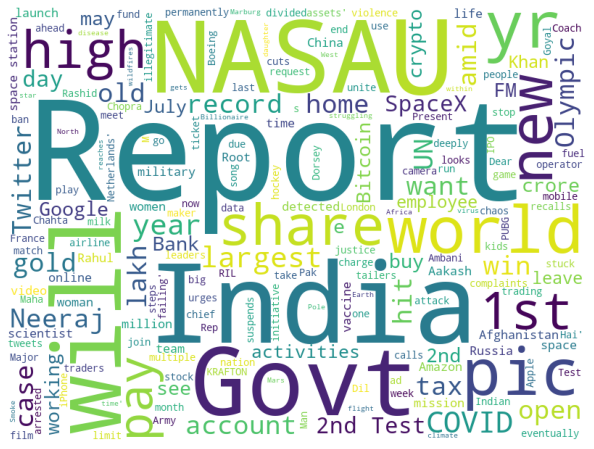

In [55]:
img = WordCloud(background_color='white', width=800, height=600).generate(lem_news_titles)
plt.figure(figsize=(16, 8))
plt.imshow(img)
plt.axis('off')

In [56]:
top_25_lem_news_bigrams = (pd.Series(nltk.ngrams(lem_news_titles.split(), 2))
                      .value_counts()
                      .head(25))

top_25_lem_news_bigrams.head(25)

(want, to)                3
(NASA, shares)            3
(to, pay)                 3
(to, get)                 3
(crore, in)               3
(has, been)               3
(I, was)                  3
(pay, cuts:)              2
(North, Pole)             2
(West, Africa?)           2
(reaches, North)          2
(world, records)          2
(deeply, divided)         2
('Dil, Chahta)            2
(virus, disease,)         2
(nation,, eventually)     2
(Test:, Aakash)           2
(2nd, Test:)              2
(get, justice:)           2
(take, steps)             2
(violence, in)            2
(Neeraj's, gold)          2
(stop, crypto-assets')    2
(out, of)                 2
(of, which)               2
dtype: int64

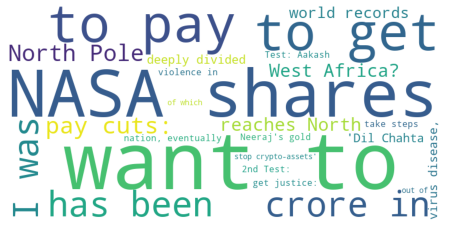

In [57]:
data = {k[0] + ' ' + k[1]: v for k, v in top_25_lem_news_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [58]:
import nltk.sentiment
sia = nltk.sentiment.SentimentIntensityAnalyzer()

In [59]:
prep_df2['sentiment'] = prep_df2.title.apply(lambda doc: sia.polarity_scores(doc)['compound'])

In [60]:
prep_df2.sentiment.mean()

-0.04925266666666668

In [61]:
news_df.category.value_counts()

science          25
entertainment    25
sports           25
business         25
technology       25
world            25
Name: category, dtype: int64

In [62]:
def clean2(text):
    '''Simplified text cleaning function'''
    text = text.lower()
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return re.sub(r"[^a-z0-9\s]", '', text)

In [102]:
sports_words = clean(' '.join(news_df[news_df.category == 'sports'].content))
science_words = clean(' '.join(news_df[news_df.category == 'science'].content))
entertainment_words = clean(' '.join(news_df[news_df.category == 'entertainment'].content))
world_words = clean(' '.join(news_df[news_df.category == 'world'].content))
tech_words = clean(' '.join(news_df[news_df.category == 'technology'].content))
business_words = clean(' '.join(news_df[news_df.category == 'business'].content))
all_words = clean(' '.join(news_df.content))

In [103]:
sports_freq = pd.Series(sports_words).value_counts()
science_freq = pd.Series(science_words).value_counts()
entertainment_freq = pd.Series(entertainment_words).value_counts()
world_freq = pd.Series(world_words).value_counts()
tech_freq = pd.Series(tech_words).value_counts()
business_freq = pd.Series(business_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [107]:
freqs = pd.concat([all_freq, sports_freq, science_freq, entertainment_freq, world_freq, tech_freq, business_freq], axis=1).fillna(0).astype(int)
freqs.columns = ['all', 'sports', 'science', 'entertainment', 'world', 'tech', 'business']
freqs.sort_values('all', ascending=False).head(25)

,all,sports,science,entertainment,world,tech,business
said,129,24,22,20,18,26,19
added,48,15,2,12,4,5,10
india,35,14,1,2,1,5,12
u,29,4,6,2,8,5,4
tuesday,24,3,0,4,9,2,6
government,23,2,0,0,9,4,8
company,23,0,1,0,2,9,11
year,22,4,5,3,3,2,5
first,21,5,8,1,4,0,3
also,21,4,1,5,5,4,2
